# CartPole by Adam Price

**author**: [Adam Price](https://adamprice.io)</br>
**repository**: [https://github.com/adamprice97/Control](https://github.com/adamprice97/Control)

Mr. Adam Price resolved the cart pole problem by applying the Particle Swarm Optimization (PSO), a Swarm Intelligence algorithm.

In [1]:
import time
import itertools
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

## What Swarm Intelligence is about?
Formally, a swarm can be defined as a group of (generally mobile) agents that communicate with each other (either directly or indirectly), by acting on their local environment.

Swarm intelligence (SI), also called collective intelligence, falls within the **bio-inspired computation**, which is a field of study which seeks to solve computer science problems using models of biology. 

SI refers to the problem-solving behavior that emerges from the interaction of agents, and computational swarm intelligence (CSI) refers to algorithmic models of such behavior. More formally, SI is the property of a system whereby the collective behaviors of unsophisticated agents interacting locally with their environment cause coherent functional global patterns to emerge.

For example, studies of social animals and social insects have resulted in a number of computational models of SI. Within these swarms, individuals are relatively simple in structure, but their collective behavior is usually very complex. The complex behavior of a swarm is a result of the pattern of interactions between the individuals of the swarm over time. This complex behavior is not a property of any single individual, and is usually not easily predicted or deduced from the simple behaviors of the individuals. This is referred to as **emergence**. More formally defined, emergence is the process of deriving some new and coherent structures, patterns and properties (or behaviors) in a complex system. These structures, patterns and behaviors come in existence without any coordinated control system, but emerge from the interactions of individuals with their local (potentially adaptive) environment.

In [2]:
# import the environment
environment_name = "CartPole-v1"
env = gym.make(environment_name, render_mode='rgb_array')

## Policy Definition
The policy used to learn the optimal position of the cart pole is a softmax, often used in reinforcement learning to convert values in probabilities.

$$P_t(a) = \frac{e^{\frac{Q_t(a)}{\tau}}}{\sum_{i=1}^{n}{e^{\frac{Q_t(a)}{\tau}}}}$$

where $Q_t(a)$ is the $Q$ function and $\tau$ a parameter called "temperature".

In [3]:
class Agent:
    def policy(self, state, tau):
        a = np.matmul(state, tau)
        return np.exp(a)/np.sum(np.exp(a))
    
agent = Agent()

## Particle Swarm Optimization
The Particle Swarm Optimization (PSO) algorithm is a population-based search algorithm based on the simulation of the social behavior of birds within a flock. The initial intent was to discover patterns that govern the ability of birds to fly synchronously, and to suddenly change direction with a re-grouping in an optimal formation.

Each particle keeps track of its coordinates in hyperspace, which are associated with the best solution (fitness) it has achieved so far. This value is called *pbest*.
The "global" version of the particle swarm optimizer keeps track of the overall best value, and its location, obtained thus far by any particle in the population; this is called *gbest*.

A PSO algorithm maintains a swarm of particles, where each particle represents a potential solution. In simple terms, the particles are "flown" through a multidimensional search space, where the position of each particle is adjusted according to its own experience and that of its neighbors. Let $x_i(t)$ denote the position of particle $i$ in the search space at time step $t$; unless otherwise stated, $t$ denotes discrete time steps. The position of the particle is changed by adding a velocity, $v_i(t)$, to the current position, i.e.:

$$x_i(t + 1) = x_i(t) + v_i(t + 1)$$

where $x_i(0) ∼ U(xmin, xmax)$.

The velocity vector drives the optimization process, and reflects both the experiential knowledge of the particle and socially exchanged information from the particle’s neighborhood. The experiential knowledge of a particle is generally referred to as the *cognitive component*, which is proportional to the distance of the particle from its own best position found since the first time step. The socially exchanged information is referred to as the social component of the velocity equation.

### Global Best PSO
The social network reflects the star topology, so the neighborhood for each particle is the entire swarm. The social component of the particle velocity update reflects information obtained from all the particles in the swarm. In this case, the social information is the best position found by the swarm, referred to as $ŷ(t)$. The velocity of particle i is calculated as:

$$v_{ij}(t + 1) = v_{ij}(t) + c_1r_{1j}(t) [ y_{ij}(t) − x_{ij}(t) ] + c_2r_{2j}(t) [ ŷ_j(t) − x_{ij}(t) ]$$

where
- $v_{ij}(t)$ is the velocity of particle i in dimension $j = 1, . . . , n_x$ at time step $t$,
- $x_{ij}(t)$ is the position of particle $i$ in dimension $j$ at time step $t$,
- $c_1$, and $c_2$ are positive acceleration constants used to scale the contribution of the cognitive and social components respectively, and 
- $r_{1j}(t)$, $r_{2j}(t) ∼ U(0, 1)$ are random values in the range $[0, 1]$, sampled from a uniform distribution.

### Inertia Weight
The inertia weight controls the momentum of the particle by weighing the contribution of the previous velocity, basically controlling how much memory of the previous flight direction will influence the new velocity. For the Global Best PSO, the velocity equation changes to:

$$v_{ij}(t + 1) = wv_{ij}(t) + c_1r_{1j}(t) [ y_{ij}(t) − x_{ij}(t) ] + c_2r_{2j}(t) [ ŷ_j(t) − x_{ij}(t) ]$$

For $w ≥ 1$, velocities increase over time, accelerating towards the maximum velocity, and the swarm diverges. Large values for $w$ facilitate exploration, with increased diversity. For w < 1, particles decelerate until their velocities reach zero. A small $w$ promotes local exploitation.

In [4]:
class ParticleSwarmOptimisation(object):
    
    def __init__(self, fitness_function, bounds, particles_number, w, velocity, c1, c2, verbose=False):
        self.__fitness_function = fitness_function
        self.__swarm = self.__create_swarm(particles_number, bounds, velocity, c1, c2)
        self.__bounds = bounds
        self.__verbose = verbose

    def __create_swarm(self, particles_number, bounds, velocity, c1, c2):
        swarm = list()
        for i in range(particles_number):
            swarm.append( Particle(bounds, w, velocity, c1, c2) )
        return swarm
    
    def maxamize(self, episodes, target):
        best_global_fitness = -np.inf
        best_global_position = list()
        best_globals_fitness = list()
        
        for episode in range(episodes):
            
            #Evaluate each particles fitness
            for particle in self.__swarm:
                fitness = particle.evaluate(self.__fitness_function)
                #Determine if current particle is new global best
                if fitness > best_global_fitness:
                    best_global_position = particle.get_best_position().copy()
                    best_global_fitness = particle.get_best_fitness()
            
            #Update velocity and positions
            for particle in self.__swarm:
                particle.update_velocity(best_global_position)
                particle.update_position(self.__bounds)     
            
            #Resample best to see if environment is solved
            best_global_fitness = self.__fitness_function(best_global_position, 100)
            best_globals_fitness.append(best_global_fitness)
            if self.__verbose:
                print('Iteration: %s, Global best: %s' % (episode, best_global_fitness))
            if best_global_fitness >= target:
                return episode, best_globals_fitness
            
        return episode, best_globals_fitness #failed to solve

In [5]:
class Particle:
    
    def __init__(self, bounds, w, velocity, c1, c2):
        self.__best_fitness = -np.inf     
        self.__best_position = list()
        self.__w, self.__c1, self.__c2  = w, c1, c2

        # initialize particle position as a uniform distribution between the lower and upper bound
        self.__position =  np.random.uniform(low=bounds[0], high=bounds[1], size=8)
        # initialize particle velocity as a uniform distribution between the lower and upper velocity
        self.__velocity = np.random.uniform(low=-velocity, high=velocity, size=8)
    
    
    def get_best_fitness(self):
        return self.__best_fitness
    
    def get_best_position(self):
        return self.__best_position

    def evaluate(self, fitness_function):
        """ Evaluate the fitness function
        
        Args:
            fitness_function: the function to be optimized
            
        Returns:
            the best fitness
        """
        fitness = fitness_function(self.__position, 25)
        #update best position
        if fitness > self.__best_fitness:
            self.__best_position = self.__position.copy()
            self.__best_fitness = fitness
        else:
            #Re-evaluate best 
            self.__best_fitness = fitness_function(self.__best_position, 25)
        return self.__best_fitness
                    
    def update_velocity(self, global_best):
        """ Update new particle velocity
        """
        velocity_local = self.__c1 * np.random.rand( (len(self.__best_position)) ) * (self.__best_position - self.__position)
        velocity_global = self.__c2 * np.random.rand( (len(self.__best_position)) ) * (global_best - self.__position)
        self.__velocity = self.__w * self.__velocity + velocity_local + velocity_global

    def update_position(self, bounds):
        """ Update the particle position
        """
        self.__position = self.__position + self.__velocity
        self.__position[self.__position < bounds[0]] = bounds[0] # set lower bound
        self.__position[self.__position > bounds[1]] = bounds[1] # set upper bound

Let's build the computation of a single episode.

In [6]:
def play_once(env, agent, policy):
    observation, _ = env.reset()
    episode_reward = 0.
    for step in itertools.count():
        probs = agent.policy(observation, policy)
        action = np.random.choice(2, p=probs)
        observation, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        if terminated or truncated:
            break
    return episode_reward

In [7]:
episodes = 10

weight_space_bounds = 8
particles_number = 15
w = 0.5 # inertia
initial_velocity_bounds = 0.25
c1 = 2 # local weight
c2 = 2 # global weight

reward_target = 500.

In [8]:
def fitness_function(position, episodes):
    policy = np.reshape(position, (4,2))
    episode_rewards = list()
    for episode in range(episodes):
        episode_reward = play_once(env, agent, policy)
        #print('Episode %s reward is %s' % (episode, episode_reward))
        episode_rewards.append(episode_reward)
    episode_rewards_mean = np.mean(episode_rewards)
    #print('average episode rewards = %s' % (episode_rewards_mean))
    return episode_rewards_mean

In [9]:
solver = ParticleSwarmOptimisation(
    fitness_function, 
    bounds=(-weight_space_bounds, weight_space_bounds),
    particles_number=particles_number,
    w=w,
    velocity=initial_velocity_bounds,
    c1=c1,
    c2=c2,
    verbose=True
)
episodes, episode_rewards = solver.maxamize(episodes, reward_target)

Iteration: 0, Global best: 130.95
Iteration: 1, Global best: 218.0
Iteration: 2, Global best: 415.13
Iteration: 3, Global best: 421.61
Iteration: 4, Global best: 441.59
Iteration: 5, Global best: 458.47
Iteration: 6, Global best: 460.51
Iteration: 7, Global best: 478.0
Iteration: 8, Global best: 476.85
Iteration: 9, Global best: 490.33


In [10]:
env.close()

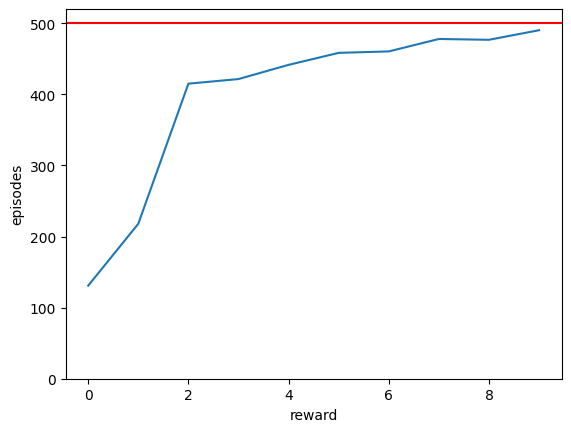

In [11]:
episode_series = range(0, episodes+1)
plt.axhline(y = env.spec.max_episode_steps, color = 'r', linestyle = '-')
plt.plot(episode_series, episode_rewards)
plt.ylim([0, env.spec.max_episode_steps+20])
plt.xlabel('reward')
plt.ylabel('episodes')
plt.show()

## References
- [The CartPole Problem — Competitive Performance With Particle Swarm Optimization](https://towardsdatascience.com/the-cartepole-problem-competitive-performance-with-particle-swarm-optimization-672f018ede3c)